<a href="https://colab.research.google.com/github/niharikaa-singh/Application-of-Groebner-Basis-in-finding-the-MLE-of-Population-Parameters-/blob/main/mle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sympy as sp
import numpy as np
from sympy.abc import l, m, n
import copy
import itertools

### Function definitions

In [ ]:
def s_poly(f, g, *gens):
    """Calculate the S-polynomial for f and g.
    This uses the default lex order.
    """
    lcm = sp.lcm(sp.LM(f, *gens), sp.LM(g, *gens))
    s = sp.simplify(lcm * (f / sp.LT(f, *gens) - g / sp.LT(g, *gens)))
    return s

In [ ]:
def buchberger(F, *gens):
    """Buchberger's Algorithm
    """
    G = copy.deepcopy(F)
    pqs = set(itertools.combinations(G, 2))
    while pqs:
        p, q = pqs.pop()
        s = s_poly(p, q, *gens)
        _, h = sp.reduced(s, G, *gens)
        if h != 0:
            for g in G:
                pqs.add((g, h))
            G.append(h)
    return G

In [ ]:
def groebner(F, *gens):
    """Calculate a reduced Groebner basis for F.
    Use the default lex order.
    """
    F_polys, opt = sp.parallel_poly_from_expr(F, *gens)
    domain = sp.EX
    ring = sp.polys.rings.PolyRing(gens, domain=domain)

    # buchberger
    G = buchberger(F_polys, *gens)

    # minimal
    temp = copy.deepcopy(G)
    G_minimal = []
    while temp:
        f0 = temp.pop()
        if not any(sp.polys.monomials.monomial_divides(f.LM(), f0.LM()) for f in temp + G_minimal):
            G_minimal.append(f0)

    # reduce
    G_reduced = []
    for i, g in enumerate(G_minimal):
        _, remainder = sp.reduced(g, G_reduced[:i] + G_minimal[i+1:])
        if remainder != 0:
            G_reduced.append(remainder)

    # sort
    # courtesy of SymPy buchberger implementation
    polys, opt = sp.parallel_poly_from_expr(G_reduced, *gens)
    polys = [ring.from_dict(poly.rep.to_dict()) for poly in polys if poly]
    G_reduced = sorted(polys, key=lambda f: f.LM, reverse=True)
    return sp.parallel_poly_from_expr([x.monic().as_expr() for x in G_reduced], *gens)[0]


In [ ]:
def is_univariate(f):
    """Returns True if 'f' is univariate in its last variable.
    Based on SymPy solve_generic
    SymPy License: https://github.com/sympy/sympy/blob/master/LICENSE
    """
    for monom in f.monoms():
        if any(monom[:-1]):
            return False
    return True


In [ ]:
def subs_root(f, gen, zero):
    """ Substitute in a solution for a generator
    Based on SymPy solve_generic
    SymPy License: https://github.com/sympy/sympy/blob/master/LICENSE
    """
    p = f.as_expr({gen: zero})

    if f.degree(gen) >= 2:
        p = p.expand(deep=False)

    return p


In [ ]:
def solve_poly_system_recursive(basis, *gens, entry=False):
    """ Recursive helper function
    Based on SymPy solve_generic
    SymPy License: https://github.com/sympy/sympy/blob/master/LICENSE
    """

    if len(basis) == 1 and basis[0].is_ground:
        if not entry:
            return []
        else:
            return None

    if len(basis) < len(gens):
        raise ValueError("System not zero-dimensional.")

    univar = [x for x in basis if is_univariate(x)]

    if len(univar) == 1:
        f = univar.pop()
    else:
        raise ValueError("System not zero-dimensional.")

    # find solutions for the univariate element
    gens = f.gens
    gen = gens[-1]

    zeros = list(sp.roots(f.ltrim(gen)).keys())

    if not zeros:
        # no solution
        return []

    # single variable
    if len(basis) == 1:
        return [(zero,) for zero in zeros]

    # recursively solve for the rest of the basis
    solutions = []
    for zero in zeros:
        new_system = []
        new_gens = gens[:-1]

        # back substitution of solution
        for b in basis[:-1]:
            eq = subs_root(b, gen, zero)

            if eq is not sp.core.S.Zero:
                new_system.append(eq)

        new_system = sp.parallel_poly_from_expr(new_system, *new_gens)[0]
        for solution in solve_poly_system_recursive(new_system, new_gens):
            solutions.append(solution + (zero,))

    if solutions and len(solutions[0]) != len(gens):
        raise ValueError("System not zero-dimensional.")

    return solutions

In [ ]:
def solve_poly_system(basis, *gens):
    """ Solve a system of polynomials with Groebner basis
    Based on SymPy solve_generic
    SymPy License: https://github.com/sympy/sympy/blob/master/LICENSE
    """
    result = solve_poly_system_recursive(basis, *gens, entry=True)
    return sorted(result , key=sp.default_sort_key)

### Example

In [ ]:
points = np.array([(11, 45, 38), (47, 54, 38), (17, 12, 14), (21, 29, 58)])

In [ ]:
N = len(points)
x = np.array([p[0] for p in points])
y = np.array([p[1] for p in points])
z = np.array([p[2] for p in points])


a = np.sum(x)
b = np.sum(np.square(x))
c = np.sum(y)
d = np.sum(np.square(y))
e = np.sum(x*y)
f = np.sum(z)
g = np.sum(y*z)
h = np.sum(np.square(z))
i = np.sum(x*z)


eq_1 = i - b*l + h*l - i*l**2 - e*m - 2*g*l*m + e*l**2*m + i*m**2 - b*l*m**2 + d*l*m**2 - e*m**3 - a*n - 2*f*l*n + a*l**2*n + 2*c*l*m*n - a*m**2*n + N*l*n**2
eq_2 = g - e*l + g*l**2 - e*l**3 - d*m + h*m - 2*i*l*m + b*l**2*m - d*l**2*m - g*m**2 + e*l*m**2 - c*n - c*l**2*n - 2*f*m*n + 2*a*l*m*n + c*m**2*n + N*m*n**2
eq_3 = f - a*l -c*m - N*n

F = [eq_1, eq_2, eq_3]
F = list(map(lambda x : sp.Poly(x), F))


### Finding Groebner Basis

In [ ]:
basis = groebner(F, l, m, n)
print(f"Reduced Groebner Basis: {basis}")

Reduced Groebner Basis: [Poly(l - 14783526575/3062641109263218243*n**6 + 11664580978195/12250564437052872972*n**5 - 587192463064675/8167042958035248648*n**4 + 18729044312276125/5444695305356832432*n**3 - 182141766251093575/1814898435118944144*n**2 + 1129975603630063727/604966145039648048*n - 7304648028039219809/604966145039648048, l, m, n, domain='QQ'), Poly(m + 23653642520/7146162588280842567*n**6 - 4665832391278/7146162588280842567*n**5 + 117438492612935/2382054196093614189*n**4 - 3745808862455225/1588036130729076126*n**3 + 36428353250218715/529345376909692042*n**2 - 662861208552047035/529345376909692042*n + 3823195132661857441/529345376909692042, l, m, n, domain='QQ'), Poly(n**7 - 734831/3490*n**6 + 121874361/6980*n**5 - 6303008853/6980*n**4 + 20977693605/698*n**3 - 1146932642007/1745*n**2 + 52839457426737/6980*n - 45252078436701/1396, l, m, n, domain='QQ')]


### Solving the system of polynomial equations using Groebner Basis

In [ ]:
solution = solve_poly_system(basis,l, m, n)
print(f"Poly Sols: {solution}")
#convert solutions to numeric data type
solution = list(map(lambda x : tuple(map(lambda y : y.evalf(), x)), solution))
print(type(solution[1][2]))
#extract real solutions from the complex solutions
real_solutions = []
for sol in solution:
    if all(isinstance(x, sp.core.numbers.Float) for x in sol):
        real_solutions.append(sol)
print(f"\nReal Sols: {real_solutions}")

Poly Sols: [(-2, 2, 15), (-1/20 + 3*sqrt(29)/20, -11/20 + 3*sqrt(29)/20, 1149/20 - 177*sqrt(29)/20), (-3*sqrt(29)/20 - 1/20, -3*sqrt(29)/20 - 11/20, 177*sqrt(29)/20 + 1149/20), (134/349 - 26*sqrt(23)*I/349 - 3*sqrt(5675654 - 2257426*sqrt(23)*I)/756632 + 35*sqrt(46)*I*sqrt(2837827 - 1128713*sqrt(23)*I)/756632, 76/349 - 46*sqrt(23)*I/349 - 3*sqrt(46)*I*sqrt(2837827 - 1128713*sqrt(23)*I)/94579 + 8*sqrt(5675654 - 2257426*sqrt(23)*I)/94579, 7037/349 - sqrt(5675654/121801 - 2257426*sqrt(23)*I/121801) + 2234*sqrt(23)*I/349), (134/349 - 35*sqrt(46)*I*sqrt(2837827 - 1128713*sqrt(23)*I)/756632 - 26*sqrt(23)*I/349 + 3*sqrt(5675654 - 2257426*sqrt(23)*I)/756632, 76/349 - 46*sqrt(23)*I/349 - 8*sqrt(5675654 - 2257426*sqrt(23)*I)/94579 + 3*sqrt(46)*I*sqrt(2837827 - 1128713*sqrt(23)*I)/94579, 7037/349 + sqrt(5675654/121801 - 2257426*sqrt(23)*I/121801) + 2234*sqrt(23)*I/349), (134/349 - 35*sqrt(46)*I*sqrt(2837827 + 1128713*sqrt(23)*I)/756632 - 3*sqrt(5675654 + 2257426*sqrt(23)*I)/756632 + 26*sqrt(23)*I/

### Finding the MLE Estimate

In [ ]:
def neg_log_likelihood_fn(x, y, z, alpha, beta, gamma):
    return np.sum(np.square(z - x*alpha - y*beta - gamma)/(1+alpha**2+beta**2))

def global_maxima(x, y, z, real_solutions):
    max_ll = -np.inf
    max_alpha = None
    max_beta = None
    max_gamma = None
    for sol in real_solutions:
        alpha, beta, gamma = sol
        ll = -neg_log_likelihood_fn(x, y, z, alpha, beta, gamma)
        if ll > max_ll:
            max_ll = ll
            max_alpha = alpha
            max_beta = beta
            max_gamma = gamma
    return max_alpha, max_beta, max_gamma, max_ll

In [ ]:
alpha, beta, gamma, ll = global_maxima(x, y, z, real_solutions)
print(f"\nAlpha: {alpha}, Beta: {beta}, Gamma: {gamma}, LL: {ll}")


Alpha: -2.00000000000000, Beta: 2.00000000000000, Gamma: 15.0000000000000, LL: -324.000000000000


### Visualization

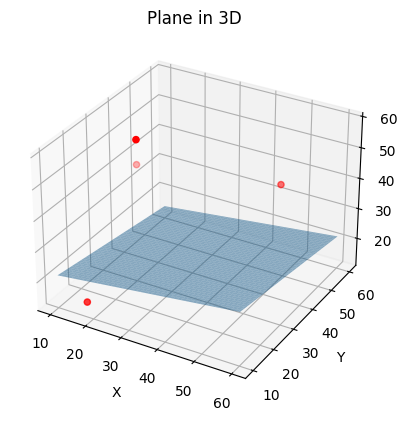

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the plane equation: ax + by + cz + d = 0
a, b, c, d = alpha, beta, gamma, ll

# Generate points on the plane
x = np.linspace(10, 60, 100)
y = np.linspace(10, 60, 100)
x, y = np.meshgrid(x, y)
z = (-a * x - b * y - d) / c

# Plot the plane
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, alpha=0.5)
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', marker='o', label='Points')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Plane in 3D')

plt.show()
